In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import contextily
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier,NeighborhoodComponentsAnalysis, NearestNeighbors
from sklearn.cluster import KMeans, DBSCAN
from sklearn.model_selection import train_test_split
import seaborn as sns
%matplotlib ipympl
from matplotlib_inline.backend_inline import set_matplotlib_formats
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}


# In this notebook we'll:

- 1. Cluster the data I've pulled from my S3 Bucket, filter it to my old neighborhood
        and add in some additional columns to make the data easier to work with.
- 2. We'll also reproject the data to another CRS to match the Census Tract Data we've pulled from OpenData
- 3. Visualize the clusters.
- 4. Examine the largest applicants to those clusters, to determine who was "most active" in my area for the
        given time period
- 5. Add in a chloropleth map to show tracts with the greatest area.

## Import and Transform

In [2]:
# Import Data -- Capture census Tracts for Visuals
data_censusTracts = gpd.read_file(r'https://opendata.arcgis.com/datasets/8bc0786524a4486bb3cf0f9862ad0fbf_0.geojson')

In [54]:
# Import Data -- see ETL_fetchData.ipynb for the extraction from S3
data = pd.read_csv(r'data\raw\destructionPermits.csv')


# Drop permits without location data
data = data.dropna(subset=['geocode_x','geocode_x'])
data = data.assign(
    # Create point Geometry with the existing CRS.
      geometry = gpd.points_from_xy(data.geocode_x,data.geocode_y,crs = 'EPSG:2272')
    # Create columns to make the data easier to work with.
    , start_month = pd.to_datetime(data.start_date).dt.to_period('M')
    , start_quarter = pd.to_datetime(data.start_date).dt.to_period('Q')
    , short_zip = data.zip.astype('str').str.split('-').apply(lambda x:x[0])
    # We'll also transform the census tract into an object type data -- that'll
    # Save us a spatial join when we go to build a chloropleth map!
    , cenTract_str = data.censustract.astype(int).astype(str)
)

# Filter Data.  in my old neighborhood -- 19145
data = data.loc[
     (data.short_zip == '19145' )

]

c:\Users\Jpric\OneDrive\Documents\Projects\Environments\conda_geo\lib\site-packages\pandas\core\arrays\datetimes.py:1143: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


In [38]:
# Convert CRS.
geoData_destructionPermits = gpd.GeoDataFrame(data).to_crs('EPSG:4326')

# Split Geometry to X and Y coordinates
geoData_destructionPermits = geoData_destructionPermits.assign(
      x = geoData_destructionPermits.geometry.x
    , y = geoData_destructionPermits.geometry.y
)

# Run DBScan, write labels to a column
  # I'm no expert on clustering algorithms, but based on working through
  # Some sample data -- this fit my need.
  # The parameters below are for :
  #   EPS         -- distance between points
  #   Min_Sample  -- Minimum required points in a cluster. 
geoData_destructionPermits = geoData_destructionPermits.assign(
    cluster_db = DBSCAN(
        eps = 0.001
      , min_samples= 3 
    ).fit(
      geoData_destructionPermits[['x','y']]
    ).labels_
)
print(geoData_destructionPermits.crs)

EPSG:4326


## Visualize

Text(0.5, 1.0, 'Cluster Analysis: Applications for L&I Destruction Permits')

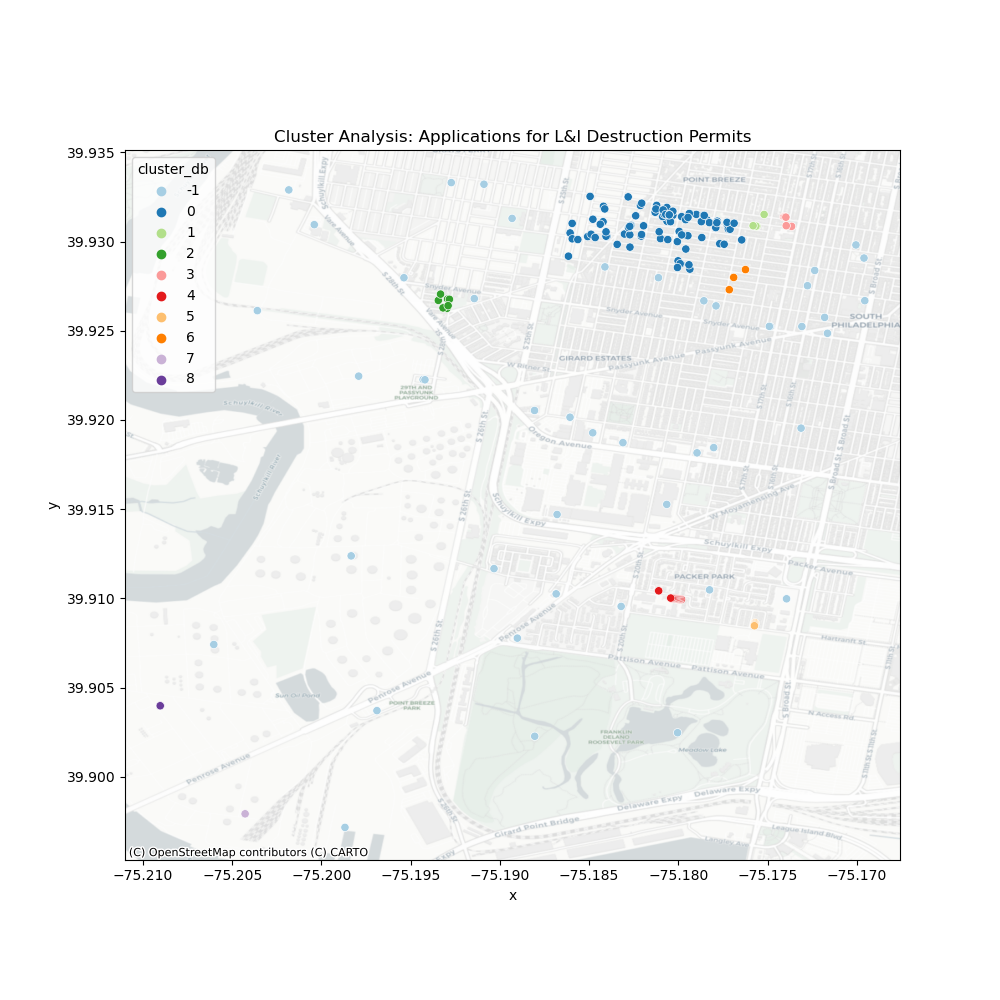

In [81]:
fig = plt.figure(figsize = (10,10))
ax = plt.subplot()

# Create Plot
#geoData_destructionPermits.plot(ax = ax, alpha = 0.2, column = 'cluster_db')
sns.scatterplot(
      x = geoData_destructionPermits.x
    , y = geoData_destructionPermits.y
    , hue = geoData_destructionPermits.cluster_db
    #, hue = geoData_destructionPermits.applicantname
    , palette = sns.color_palette('Paired',n_colors=geoData_destructionPermits.cluster_db.value_counts().shape[0])
)

# Add context layer
contextily.add_basemap(ax = ax,source = contextily.providers.CartoDB.Positron,crs = geoData_destructionPermits.crs.to_string())

ax.set_title('Cluster Analysis: Applications for L&I Destruction Permits')

### Some thoughts on the visual above
    - 0. After some investigation, it might be worth renaming these clusters.  Also, the -1 cluster (No Cluster) and Cluster 0 are definitely too close in color to one another.
    
    - 1. Cluster 0 is very dense and very large.  Who is most active in this area, and how long has work here been going on for?

    - 2. Generally speaking, any of the smaller clusters are very interesting to me -- what's going on in regions like Packer Park (Clus3 + Clus4) and South of Snyder Avenue (Clus2) 

    - 3. As well -- Clus7 and Clus8 must be either the same addresses over again (they must have >3 occurences) or the addresses are right on top of one another (I think this is unlikely)


In [27]:
# What are the years of activity?
# Who is applying for Destruction Permits and for
    # What clusters are they applying for them?
geoData_destructionPermits.pivot_table(
      index = [
              'cluster_db'
        ]
    , aggfunc = ['min','max','count']
    , values = 'start_quarter'
)

# This helps to provide context on Custer 0 -- this is work that's been underway since early 2008 and continues to this day!

,min,max,count
,start_quarter,start_quarter,start_quarter
cluster_db,,,
-1,2007Q1,2023Q1,50
0,2008Q1,2023Q1,91
1,2011Q1,2015Q2,4
2,2012Q2,2022Q4,7
3,2014Q2,2022Q4,5
4,2012Q2,2016Q4,11
5,2013Q4,2013Q4,4
6,2019Q1,2021Q4,3


In [29]:
# What are the number of unique applicants to each cluster?
# What are the years of activity?
# Who is applying for Destruction Permits and for
    # What clusters are they applying for them?
geoData_destructionPermits.pivot_table(
      index = [
              'cluster_db'
        ]
    , aggfunc = [pd.Series.nunique,'count']
    , values = 'applicantname'
)

# Here we can see clearly that Cluster7 and Cluster8 are definitely just the same applicants, with multiple recurring applications! 
# We can also see that there are a lot of different applicants in Cluster0 -- there's a lot happening in that region!


,nunique,count
,applicantname,applicantname
cluster_db,,
-1,31,50
0,23,91
1,2,4
2,1,7
3,2,5
4,2,11
5,4,4
6,1,3


In [50]:
# Who is applying for Destruction Permits and for Cluster 0???
geoData_destructionPermits.pivot_table(
      index = [
              'cluster_db'
            , 'applicantname'
            , 'address'
            , 'start_quarter'
        ]
    , aggfunc = 'count'
    , values = 'cartodb_id'
).loc[
    (4)
].sort_values('cartodb_id',ascending = False)

# Cluster 4 is mostly a single applicant.
# It looks like this was the Holy Spirit Rectory.

cartodb_id
applicantname              address        start_quarter            
MOST REV JOHN J KROL       1900 GEARY ST  2012Q2                  1
                           1902 GEARY ST  2012Q2                  1
                           1904 GEARY ST  2012Q4                  1
                           1906 GEARY ST  2012Q2                  1
                           1908 GEARY ST  2012Q2                  1
                           1910 GEARY ST  2012Q2                  1
                           1912 GEARY ST  2012Q2                  1
                           1914 GEARY ST  2012Q2                  1
                           1916 GEARY ST  2012Q2                  1
                           1918 GEARY ST  2012Q2                  1
WALKER JOHN & STURGES BRYA 3195 S UBER ST 2016Q4                  1

In [53]:
# Who is applying for Destruction Permits and for Cluster 0???
geoData_destructionPermits.pivot_table(
      index = [
              'cluster_db'
            , 'applicantname'
            , 'typeofwork'
        ]
    , aggfunc = 'count'
    , values = 'cartodb_id'
).loc[
    (0,slice(None),slice(None))
].sort_values('cartodb_id',ascending = False)

# I'd have to do more research on "Case" type records -- we could look at the L&I website
# But we'll call this question looked into for now!

cartodb_id
cluster_db applicantname                                      typeofwork                  
0          CITY OF PHILADELPHIA DEPT. OF L&I DBA: CONTRACT... CASE                      59
                                                              MINOR DEMOLITION           6
           ANTWAN BRAAF DBA: ADELPHIA DEMOLITION, INC.        MINOR DEMOLITION           4
           JOVANNY RAMOS DBA: SUPREME ARCHITECTS, LLC         MINOR DEMOLITION           2
           1615 N 22 ST LLC                                   MINOR DEMOLITION           1
           TJOKRONOLO DUNUNG G      KHAWAJA ATIF              FULL                       1
           SUSAN UHL DBA: LANDMARK ARCHITECTURAL DESIGN, LLC  MINOR DEMOLITION           1
           RLM DEVELOPMENT LLC                                FULL                       1
           PROPERTY SOLVERS LLC                               FULL                       1
           NEPTUNE HARVEY R                                   FULL                       1
           MGS REALTY LLC                                     MINOR DEMOLITION           1
           MAX VALUE INVESTMENT LLC                           FULL                       1
           LOMBARDO PETER                                     FULL                       1
           HUANG RENMIN                                       MINOR DEMOLITION           1
           JOHN CHRISTINZIO DBA: QUEST DESIGN SERVICES, LLC   MINOR DEMOLITION           1
           HARGADEN LIAM                                      FULL                       1
           GM HOME INC                                        FULL                       1
           GLOBAL PROPERTIES GROUP L                          FULL                       1
           EDWARD J URBAN           VIRGINIA M                MINOR DEMOLITION           1
           DEMOLITION MAN LLC                                 MINOR DEMOLITION           1
           BROAVA CHELLA LLC                                  FULL                       1
           BARKER ANNA                                        FULL                       1
           AVID HOLDINGS LLC                                  FULL                       1
           WSW POINT BREEZE HOLDINGS                          FULL                       1

# Chloropleth Mapping

- To build a chloropleth map of the data we have here, we could do a spatial join using the existance of a destruction permit 
within a census tract.  Luckily, the L&I Data actually gives us the census tract for each application -- so we'll
use a typical left merge onto our census tract id table instead.

In [63]:
# Aggregate
geoData_censusTractJoin = geoData_destructionPermits.pivot_table(
      index = 'cenTract_str'
    , aggfunc = 'count'
    , values = 'cartodb_id'
)

# Merge and drop columns without aggregate data -- we only want to visualize census tracts
# With data
data_censusTracts_forChloro = data_censusTracts.merge(
      geoData_censusTractJoin
    , how = 'left'
    , left_on = 'NAME10'
    , right_index = True
)

data_censusTracts_forChloro = data_censusTracts_forChloro.loc[
    data_censusTracts_forChloro.cartodb_id.notna()
]


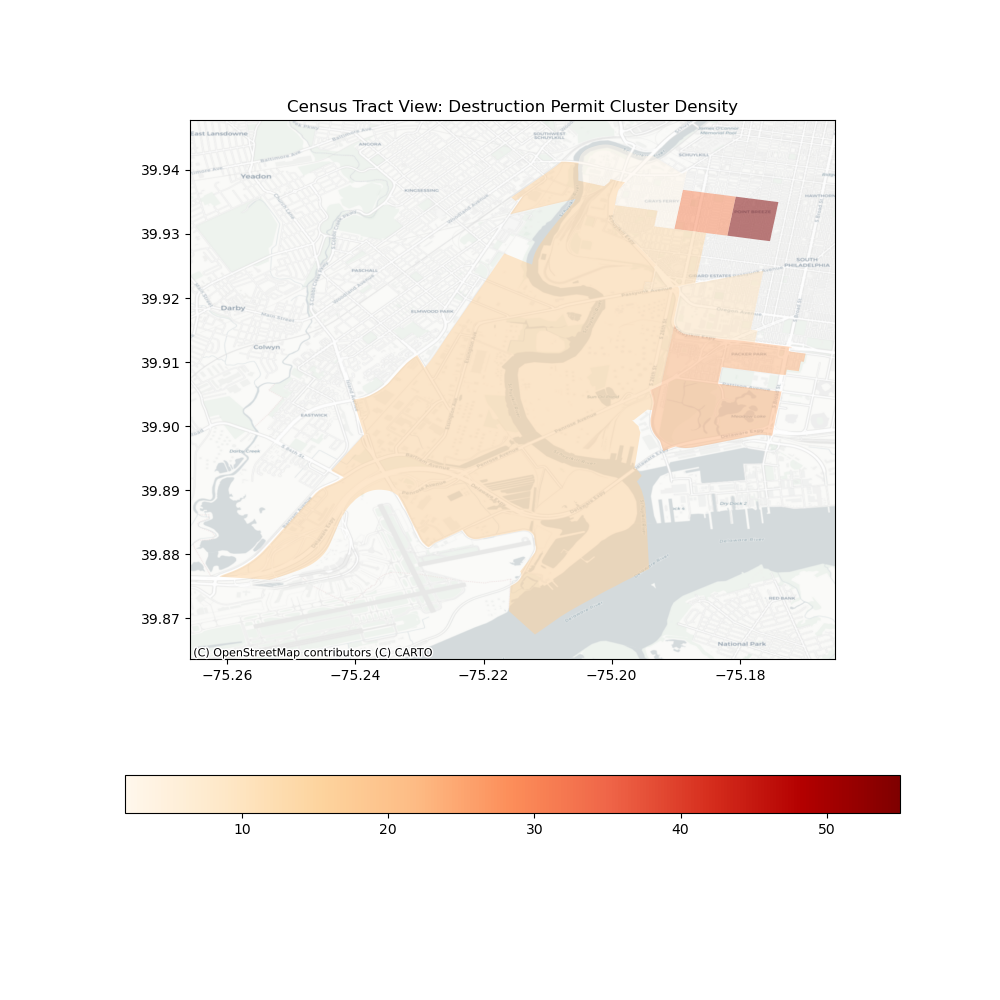

In [79]:
# Visualize the Chloropleth
# We'll take advantage of GeoPandas built in functions for this
censusTract_chlor = data_censusTracts_forChloro.plot(
        column = 'cartodb_id'
      , alpha = 0.5
      , cmap = 'OrRd'
      , legend = True
      , legend_kwds={"orientation": "horizontal"}
      , figsize= (10,10)
)

censusTract_chlor.set_title('Census Tract View: Destruction Permit Cluster Density')
contextily.add_basemap(ax = censusTract_chlor,source = contextily.providers.CartoDB.Positron,crs = data_censusTracts_forChloro.crs.to_string())